# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

plt.style.use("dark_background")

You should consider upgrading via the 'C:\Users\blanc\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
#from google_drive_downloader import GoogleDriveDownloader as gdd
#gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
#dest_path='./dataTP.npz')
#gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
#dest_path='./AtlasAAL2.nii')
#gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
#dest_path='./AtlasAICHA.nii')
#gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
#dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [3]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

C:\Users\blanc\AppData\Local\Programs\Python\Python310\lib\site-packages\nilearn\plotting\img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


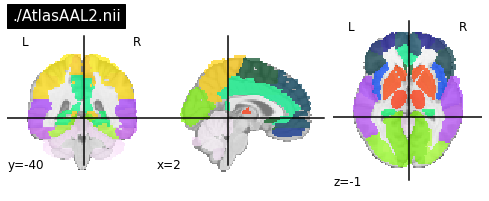

In [4]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [5]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 666)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

We normalize the data


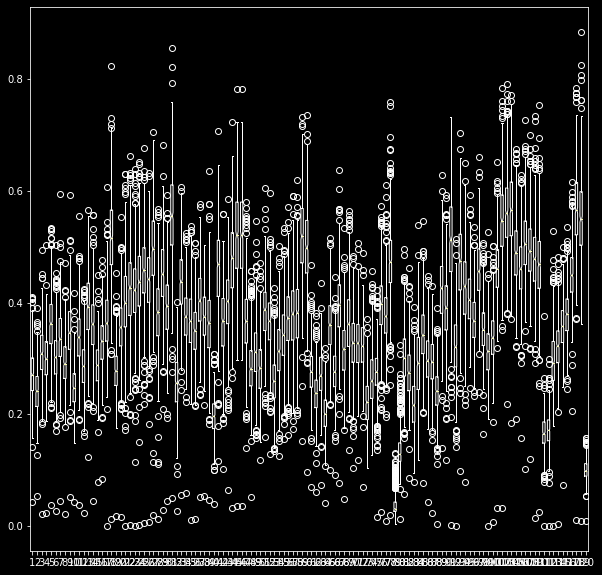

In [6]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

# Standardization/Normalization
if X.min() <0 :
    print("We standardize the data")
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
else:
    print("We normalize the data")
    normalizer = Normalizer()
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [7]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=666)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7606382978723404


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 

**Answer** : Le random_state ne change pas les meilleurs valeurs de `min_samples_leaf` ni de `min_samples_leaf` aussi bien pour le train score que le test score, même si les valeurs exactes de ces scores sont légérement différentes. On obtient assez logiquement que pour les données d'entrainement la meilleure valeur est 2. La meilleure valeur pour les données de test est 12. Pour min_samples_leaf on obtient de nouveau 2 pour le train score et on a 6 pour le test score.


Using random_state= 130
The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  12
Using random_state= 173
The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  12
Using random_state= 158
The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  2
Using random_state= 62
The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  12
Using random_state= 70
The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  12


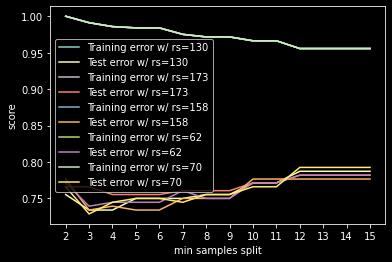

In [8]:
# min_samples_split
rand_s = np.random.randint(0,200,size=5)
for k in range(5):
    print("Using random_state=",rand_s[k])
    TTest=[]
    TTrain=[]
    for i in range(2,16):
        Tree = DecisionTreeClassifier(min_samples_split=i, random_state=rand_s[k])
        Tree.fit(X_train,y_train)
        scoreTrain=Tree.score(X_train,y_train)
        scoreTest=Tree.score(X_test,y_test)
        TTrain.append(scoreTrain)
        TTest.append(scoreTest)
    plt.plot(TTrain,label='Training error w/ rs='+str(rand_s[k]));
    plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
    print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
    plt.plot(TTest,label='Test error w/ rs='+str(rand_s[k]));
    plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
    plt.xlabel('min samples split')
    plt.ylabel('score')
    print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
    plt.legend()

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  6
The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  7
The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  6
The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  6
The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  6


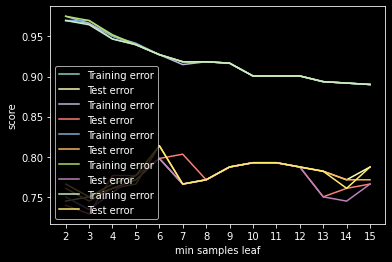

In [9]:
# min_samples_leaf
rand_s = np.random.randint(0,200,size=5)
for k in range(5):
    TTest=[]
    TTrain=[]
    for i in range(2,16):
        Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=rand_s[k])
        Tree.fit(X_train,y_train)
        scoreTrain=Tree.score(X_train,y_train)
        scoreTest=Tree.score(X_test,y_test)
        TTrain.append(scoreTrain)
        TTest.append(scoreTest)
    plt.plot(TTrain,label='Training error');
    plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
    print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
    plt.plot(TTest,label='Test error');
    plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
    plt.xlabel('min samples leaf')
    plt.ylabel('score')
    print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend()

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer** : On constate que les résultats ne sont pas stables du tout et qu'en plus le modèle est très sensible au bruit.

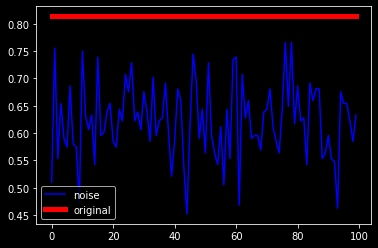

In [10]:
Tree = DecisionTreeClassifier(min_samples_split=12,min_samples_leaf=6,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)  

sigma = 0.1

for k in range(100):    
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] = X_train[i] + np.abs(np.random.normal(0,sigma))
        
    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

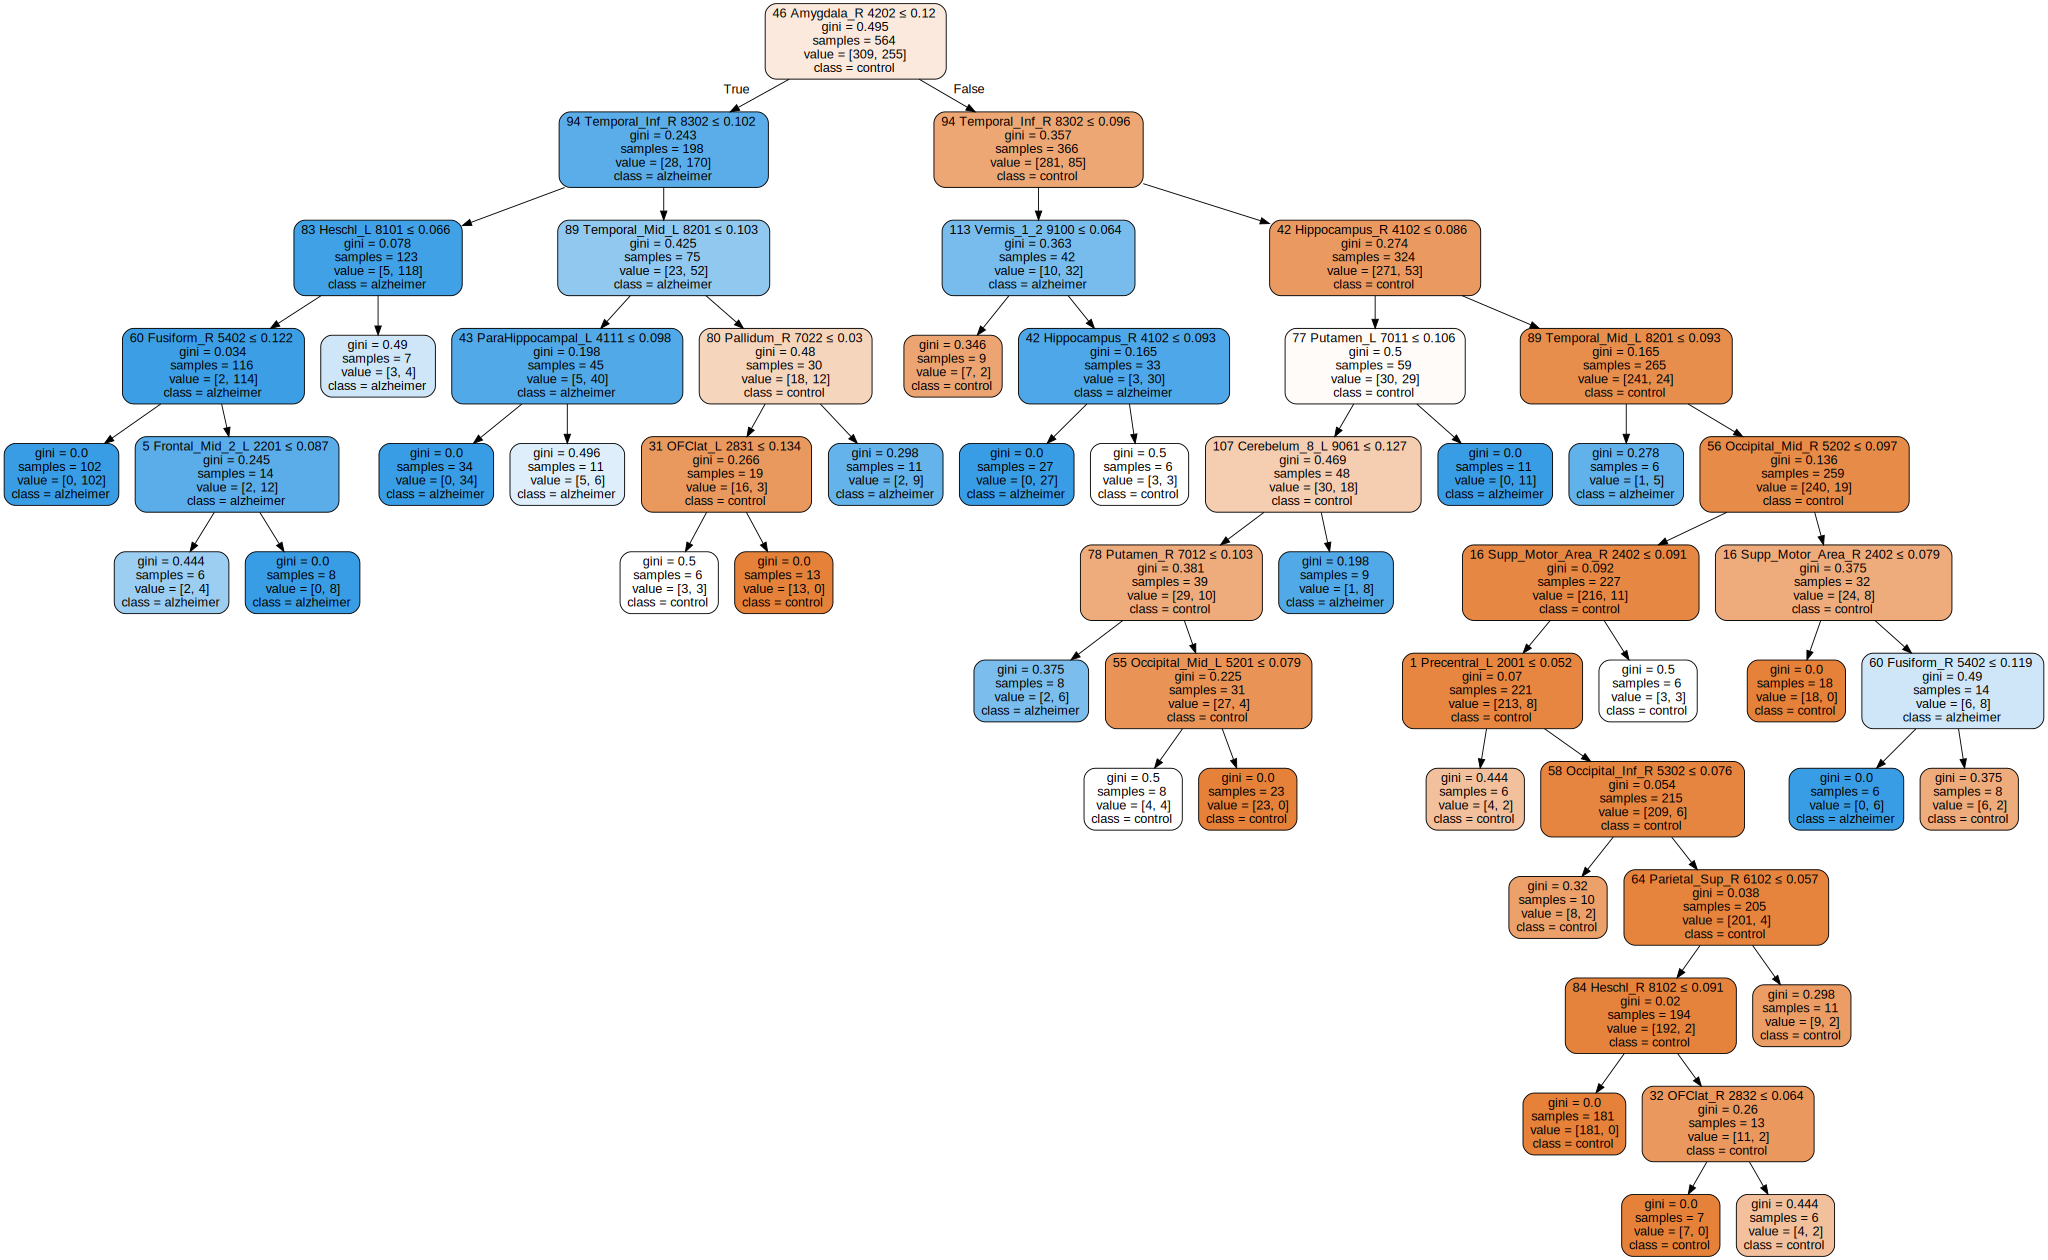

In [11]:
import graphviz 
Tree = DecisionTreeClassifier(min_samples_split=12,min_samples_leaf=6,random_state=0)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer** : On obtient des arbres différents. On constate aussi que plus le bruit est important plus il va falloir de noeuds pour déterminer la classe d'une données.

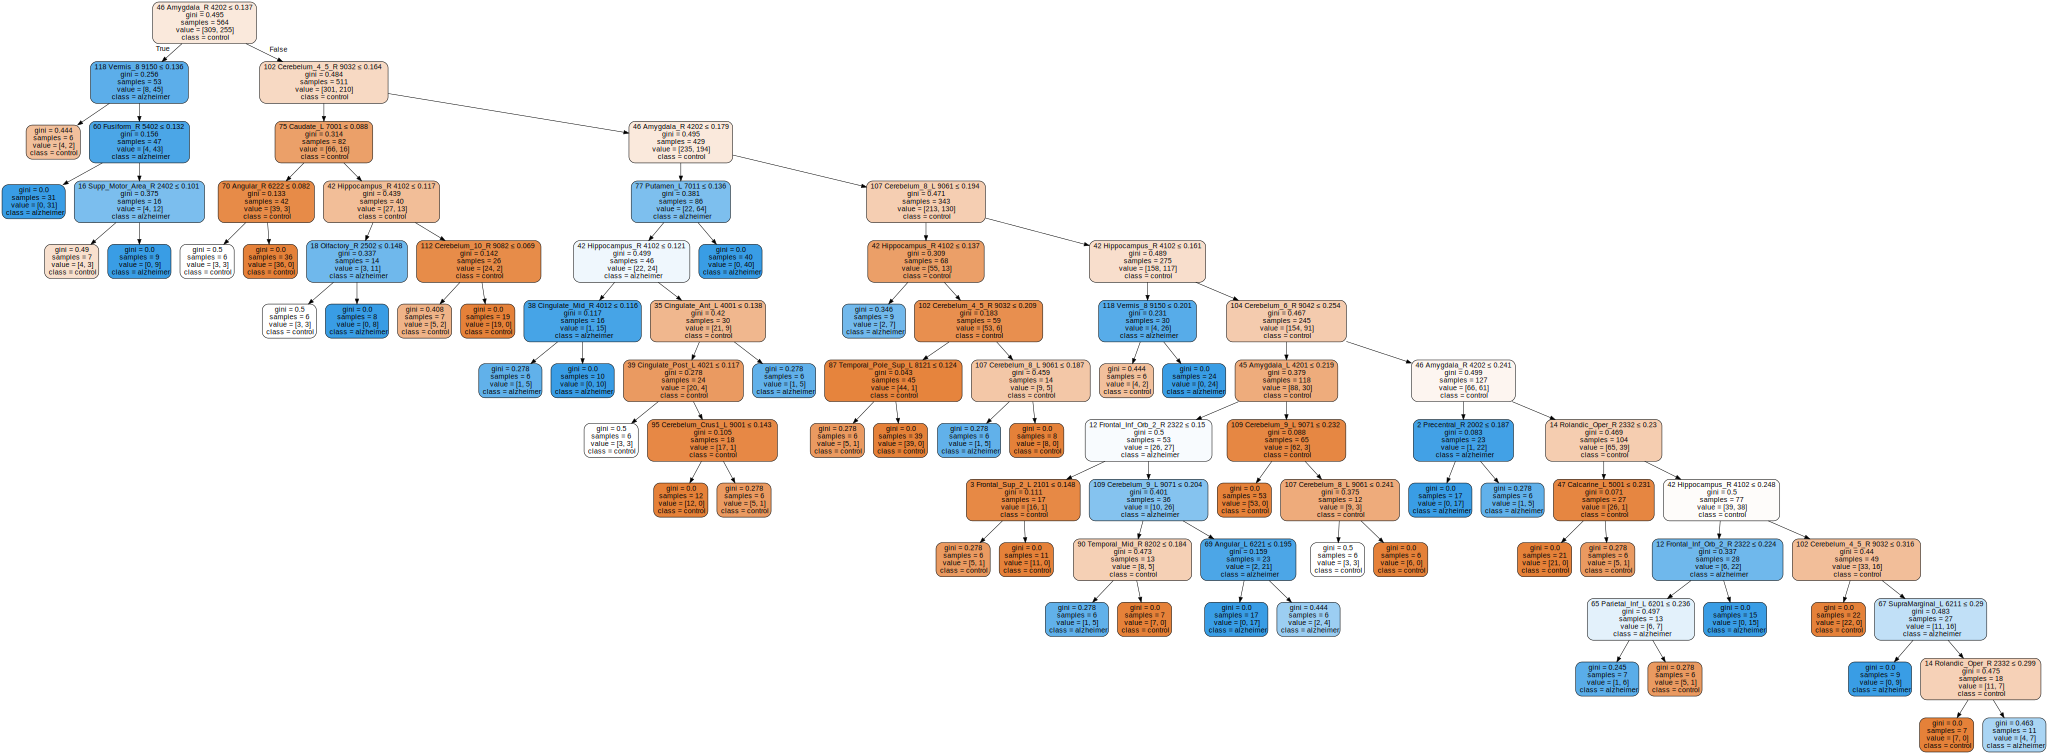

In [12]:
Tree = DecisionTreeClassifier(min_samples_split=12,min_samples_leaf=6,random_state=0)
Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Answer** : On obtient des résultats différents de ce que l'on avait tout à l'heure.

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer** : On constate que les classes ne sont pas tout à fait équilibrée, pour prendre en compte ce phénomène on pourrait prendre comme score la `balanced_accuracy`.

In [13]:
Tree = DecisionTreeClassifier(random_state=666)
p_grid_tree = {'min_samples_split' : [k for k in range(2,16)], 'min_samples_leaf' : [k for k in range(2,16)] } 
grid_tree = GridSearchCV(Tree,param_grid=p_grid_tree, scoring='balanced_accuracy')
grid_tree.fit(X_train,y_train)
best_params= grid_tree.best_params_
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

Best Validation Score: 0.8094550035773167
Best params: {'min_samples_leaf': 13, 'min_samples_split': 2}
Tree test score : 0.7664128302757587


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer** : On constate que maintenant les régions d'intéret sont bien plus proches de la racine qu'avec les autres méthodes. C'est-à-dire que l'arbre est en mesure de déterminer fidèlement les classes d'une donnée en regardant moins de features.

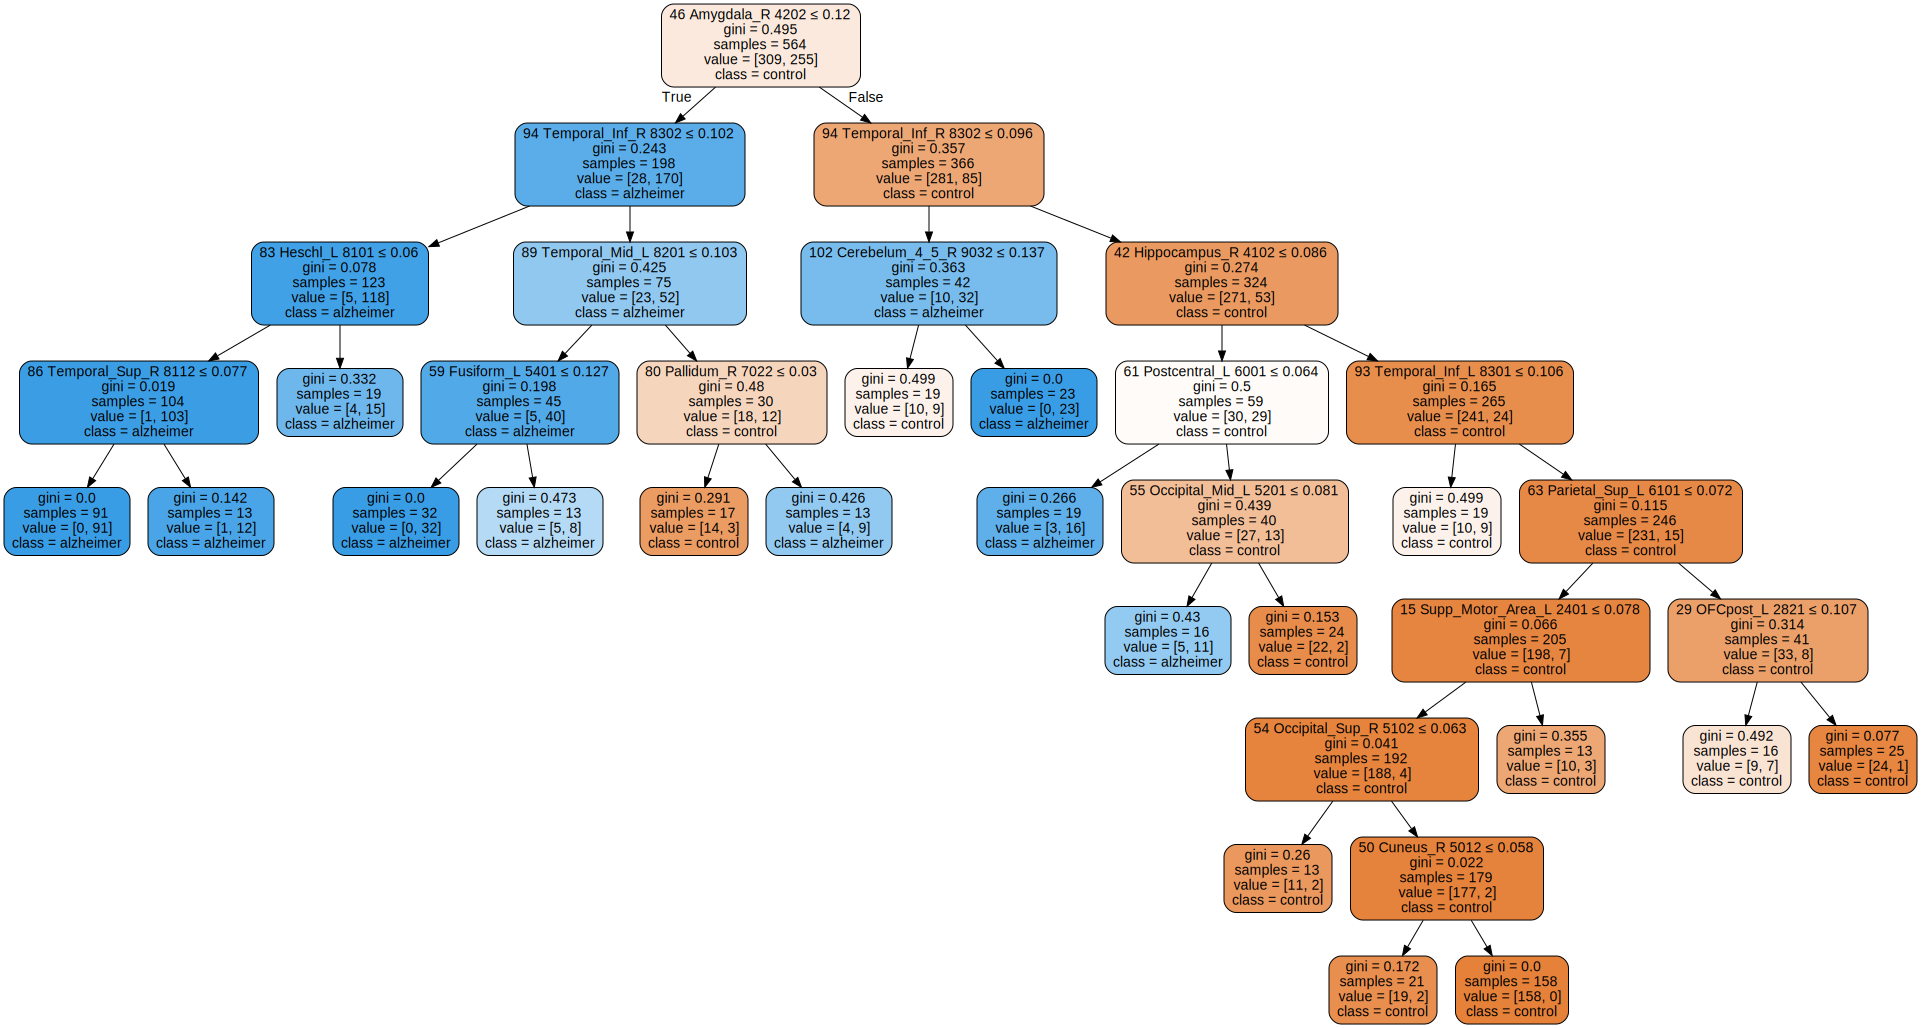

In [14]:
Tree = DecisionTreeClassifier(min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'])
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

**Answer** : On constate qu'on obtient à la fois un score d'entrainement mais aussi un score de prédiction meilleur que précédemment. On a aussi des résultats qui sont moins mauvais sur les données bruitées. Sur les données bruitées on a un score d'entrainement très proche du score de prédiction.

In [15]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=666)

p_grid_bagging = {'n_estimators': [k for k in range(1,30)]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid= p_grid_bagging)
grid_bagging.fit(X_train, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test.ravel()))

Best Validation Score: 0.8563843236409607
Best params: {'n_estimators': 21}
Bagging test score : 0.8297872340425532


In [16]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=666)

p_grid_bagging = {'n_estimators': [5,10,15,20,21]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid= p_grid_bagging)
grid_bagging.fit(X_train_temp, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test.ravel()))

Best Validation Score: 0.7446586599241467
Best params: {'n_estimators': 21}
Bagging test score : 0.5319148936170213


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [17]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='balanced_accuracy', cv=5)
grid_RF.fit(X_train, y_train.ravel())
best_params = grid_RF.best_params_
print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test.ravel()))

Best Validation Score: 0.8719263591211206
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 30}
Random Forest test score : 0.8066228221991462


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

Comparé aux autres modèles entrainés sur des données bruitées on obtient des meilleurs résultats même si le score de prédiction reste inférieur à celui des modèles entrainés sur les données non bruitées.

In [18]:
# Random Forest on noisy data
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train_temp,y_train.ravel())
print("Training score : {}".format(RF.score(X_train_temp,y_train)))
print("Test score : {}".format(RF.score(X_test,y_test)))

Training score : 0.973404255319149
Test score : 0.5797872340425532


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.090091)
2. feature 40 representing 41 Hippocampus_L 4101
 (0.074341)
3. feature 93 representing 94 Temporal_Inf_R 8302
 (0.065022)
4. feature 43 representing 44 ParaHippocampal_R 4112
 (0.064267)
5. feature 41 representing 42 Hippocampus_R 4102
 (0.064103)
6. feature 44 representing 45 Amygdala_L 4201
 (0.057087)
7. feature 92 representing 93 Temporal_Inf_L 8301
 (0.054329)
8. feature 59 representing 60 Fusiform_R 5402
 (0.040721)
9. feature 88 representing 89 Temporal_Mid_L 8201
 (0.032124)
10. feature 89 representing 90 Temporal_Mid_R 8202
 (0.023926)


C:\Users\blanc\AppData\Local\Temp\ipykernel_1156\1997444764.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train,y_train)


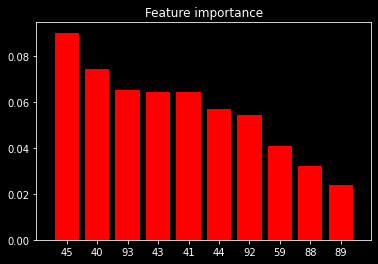

In [19]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

**Answer** : On retrouve bien que l'hyppocampe et l'amydale sont déterminantes dans le diagnostic de cette maladie.

We can also inspect the data using only pairs of the most important features

With the features [45, 40] we get the training score 0.8794326241134752
With the features [45, 93] we get the training score 0.8687943262411347
With the features [45, 43] we get the training score 0.8457446808510638
With the features [40, 93] we get the training score 0.8882978723404256
With the features [40, 43] we get the training score 0.8368794326241135
With the features [93, 43] we get the training score 0.8421985815602837


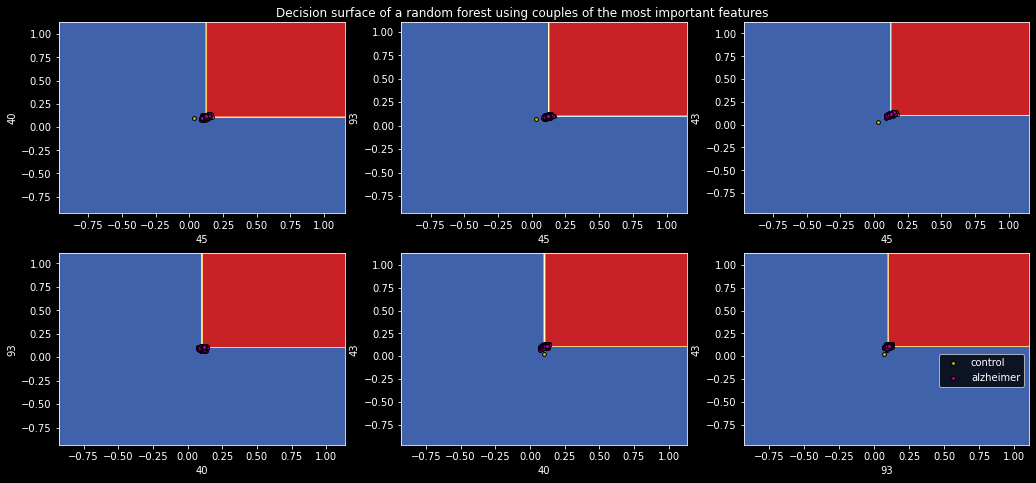

In [20]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair.ravel())
    print("With the features",pair,"we get the training score",clf.score(Xpair,ypair))
    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer** : Au vu des scores, il apparait que le meilleur couple de paramètres à considérer est  (Hippocampus_L, Temporal_Inf_R).

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

On va travailler avec des Randoms Forest puisque c'était le meilleur modèle sur l'atlas précédent. On constate que si on overfit moins le modèle sur l'atlas Aicha, on a de moindres performances. Sur l'atlas Hammers on a certe plus overfit le modèle mais on obtient de meilleurs scores de prédiction qu'avec les deux autres atlas.

Pour résumer on trouve sur les atlas les features suivantes : 
AAL2 :
1. feature 45 representing 46 Amygdala_R 4202 (0.090091)
2. feature 40 representing 41 Hippocampus_L 4101 (0.074341)
3. feature 93 representing 94 Temporal_Inf_R 8302 (0.065022)
4. feature 43 representing 44 ParaHippocampal_R 4112 (0.064267)
5. feature 41 representing 42 Hippocampus_R 4102 (0.064103)

Aicha :
1. feature 144 representing 145	S_Parietooccipital-4	146 (0.109734)
2. feature 173 representing 174	N_Caudate-1	175 (0.031545)
3. feature 180 representing 181	N_Pallidum-1	182 (0.027456)
4. feature 187 representing 188	N_Thalamus-5	189 (0.024399)
5. feature 183 representing 184	N_Thalamus-1	185 (0.022342)

Hammer : 
1. feature 3 representing Right Amygdala                         (0.100402)
2. feature 16 representing Left Cerebellum                        (0.076501)
3. feature 0 representing Left Hippocampus                       (0.056808)
4. feature 2 representing Left Amygdala                          (0.044963)
5. feature 17 representing Right Cerebellum                       (0.040139)


On voit donc bien finalement les meilleurs marqueurs à regarder pour la maladie d'Alzheimer sont les amygdales et l'hippocampe (comme conclu dans les papiers). 

**AICHA Atlas** :

In [21]:
# Choose Atlas (here AAL2)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))
print('X.min() :',X.min())

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 666)

print("We normalize the data")
normalizer = Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192
X.min() : 0.0
We normalize the data


In [22]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='balanced_accuracy', cv=5)
grid_RF.fit(X_train, y_train.ravel())
best_params = grid_RF.best_params_
print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test.ravel()))

Best Validation Score: 0.7705244657355275
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 20}
Random Forest test score : 0.7523941386869736


Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.109734)
2. feature 173 representing 174	N_Caudate-1	175
 (0.031545)
3. feature 180 representing 181	N_Pallidum-1	182
 (0.027456)
4. feature 187 representing 188	N_Thalamus-5	189
 (0.024399)
5. feature 183 representing 184	N_Thalamus-1	185
 (0.022342)
6. feature 117 representing 118	S_Cingulate-5	119
 (0.021564)
7. feature 188 representing 189	N_Thalamus-6	190
 (0.019514)
8. feature 170 representing 171	G_Fusiform-6	172
 (0.019094)
9. feature 157 representing 158	G_Lingual-6	159
 (0.018733)
10. feature 186 representing 187	N_Thalamus-4	188
 (0.018346)


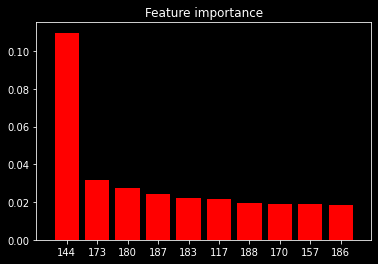

In [23]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Hammers Atlas** : 

In [24]:
# Choose Atlas (here AAL2)
X=T1HAMMERS # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsHAMMERS # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))
print('X.min() :',X.min())

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 666)

print("We normalize the data")
normalizer = Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68
X.min() : 0.0
We normalize the data


In [25]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='balanced_accuracy', cv=5)
grid_RF.fit(X_train, y_train.ravel())
best_params = grid_RF.best_params_
print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test.ravel()))

Best Validation Score: 0.8648526041828684
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 15}
Random Forest test score : 0.8159686165916695


Feature ranking:
1. feature 3 representing Right Amygdala                         (0.100402)
2. feature 16 representing Left Cerebellum                        (0.076501)
3. feature 0 representing Left Hippocampus                       (0.056808)
4. feature 2 representing Left Amygdala                          (0.044963)
5. feature 17 representing Right Cerebellum                       (0.040139)
6. feature 59 representing Right Superior Frontal Gyrus           (0.040069)
7. feature 65 representing Right Lingual Gyrus                    (0.036602)
8. feature 1 representing Right Hippocampus                      (0.032315)
9. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.028604)
10. feature 13 representing Right Inferior Middle Temporal Gyri    (0.027671)


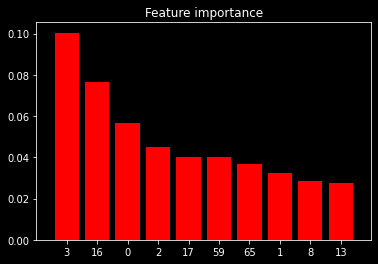

In [26]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()